In [27]:
# Libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(cowplot)

Warning message:
“package ‘cowplot’ was built under R version 4.0.3”


In [15]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
download.file(url, "student.zip")
unzip("student.zip")
student_data <- read_delim("student-por.csv", delim=";") 
nrow(student_data)
nrow(filter(student_data, na.rm = TRUE))
# Since the number of rows before and after filter for missing observations is the same, there are no missing observations in the data
head(student_data)

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



[1] 649

[1] 649

school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,4,0,11,11
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,2,9,11,11
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,6,12,13,12
GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,0,14,14,14
GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,0,11,13,13
GP,M,16,U,LE3,T,4,3,services,other,⋯,5,4,2,1,2,5,6,12,12,13


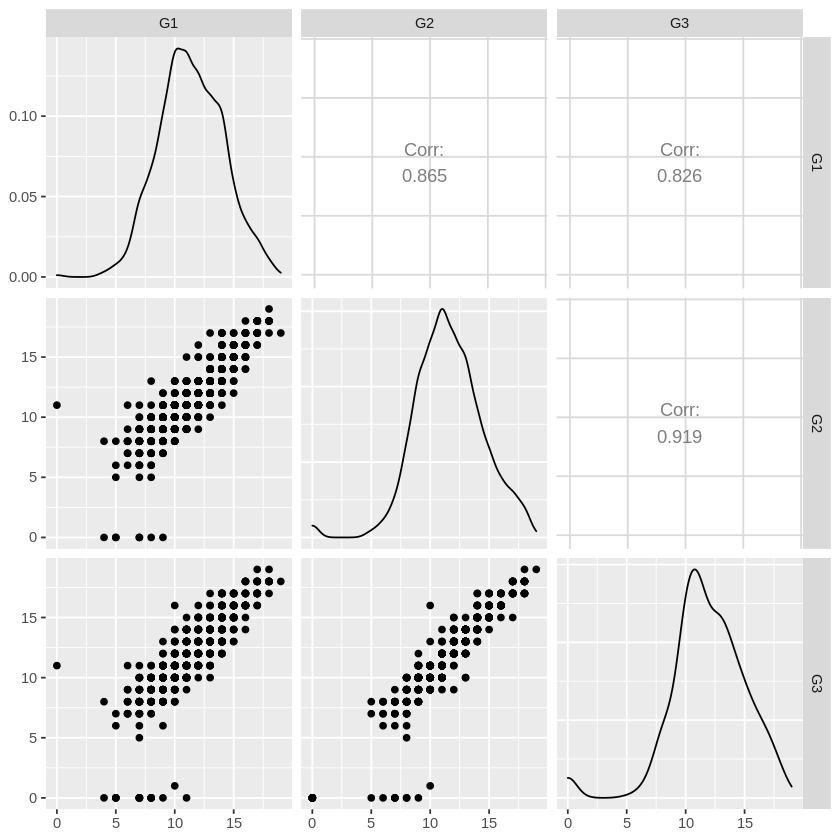

In [13]:
student_select <- select(student_data, G1, G2, G3)
predictor_visualization <- ggpairs(student_select)
predictor_visualization
# High correlation

In [16]:
set.seed(1234)
student_split <- initial_split(student_select, prop = 0.75, strata = G3)
student_training <- training(student_split) 
student_testing <- testing(student_split)
head(student_training)

G1,G2,G3
<dbl>,<dbl>,<dbl>
0,11,11
9,11,11
12,13,12
14,14,14
11,13,13
12,12,13


In [24]:
student_statistics <- student_training %>%
summarize("Number of Rows" = nrow(student_training),
         "Mean of G1" = mean(G1),
         "Mean of G2" = mean(G2),
         "Mean of G3" = mean(G3),
         "Median of G1" = median(G1),
         "Median of G2" = median(G2),
         "Median of G3" = median(G3))
student_statistics

Number of Rows,Mean of G1,Mean of G2,Mean of G3,Median of G1,Median of G2,Median of G3
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
488,11.37295,11.58607,11.89754,11,11,12


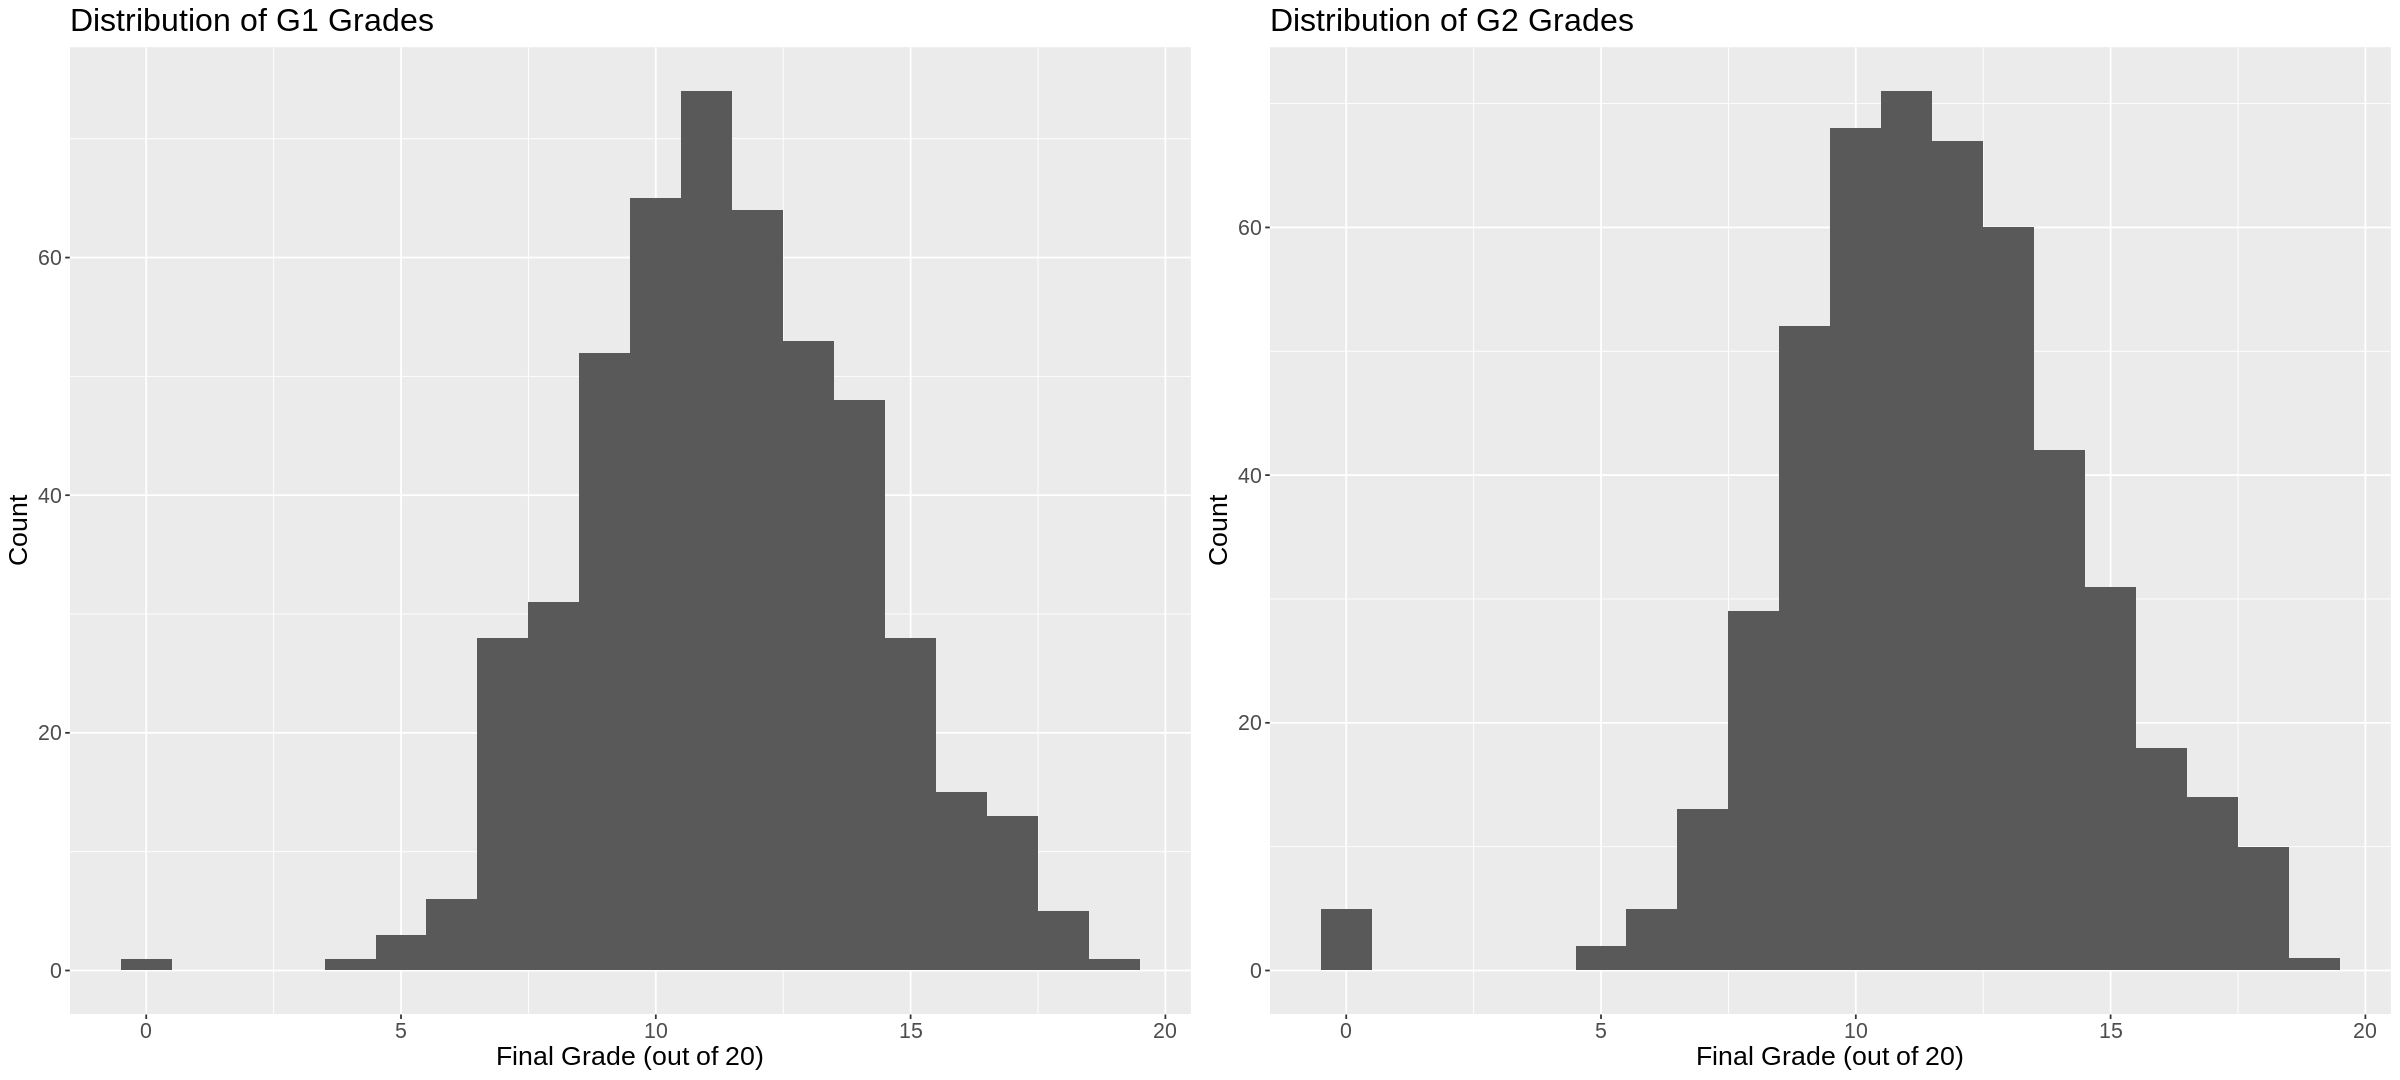

In [34]:
options(repr.plot.width = 20, repr.plot.height = 9)
g1_distribution <- ggplot(student_training, aes(x = G1))+
geom_histogram(bins = 20)+
labs(x = "Final Grade (out of 20)", y = "Count")+
theme(text = element_text(size = 16))+
ggtitle("Distribution of G1 Grades")
g2_distribution <- ggplot(student_training, aes(x = G2))+
geom_histogram(bins = 20)+
labs(x = "Final Grade (out of 20)", y = "Count")+
theme(text = element_text(size = 16))+
ggtitle("Distribution of G2 Grades")
predictor_distribution <- plot_grid(g1_distribution,
                                    g2_distribution,
                                    ncol = 2)
predictor_distribution